In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.join(module_path, 'cnn-keras-update'))

In [2]:
%matplotlib inline

from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.regularizers import *
import keras.backend as K
import numpy as np

import fs
import models
from models.googlenet_custom_layers import PoolHelper, LRN
import utils
import plot_utils

Using Theano backend.
Using gpu device 0: Quadro K620M (CNMeM is disabled, cuDNN 5004)


In [3]:
model = load_model('../cnn-keras-update/results/2017-01-20_12:58:44/best_model.h5',  custom_objects={"LRN": LRN})


['nvcc', '-shared', '-O3', '--maxrregcount=32', '-arch=sm_50', '-m64', '-Xcompiler', '-fno-math-errno,-Wno-unused-label,-Wno-unused-variable,-Wno-write-strings,-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray', '-I/home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray', '-I/usr/local/cuda-7.5/include', '-I/usr/local/lib/python3.5/dist-packages/numpy/core/include', '-I/usr/include/python3.5m', '-I/usr/local/lib/python3.5/dist-packages/theano/gof', '-I/usr/local/lib/python3.5/dist-packages/theano/sandbox/cuda', '-o', '/home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/tmp2vpnnq6l/m533116516f0283ee900cdfe68923ba01.so', 'mod.cu', '-L/home/ckoerner/.theano/compiledir_Linux-4.4

1 #include <Python.h>
2 #include <iostream>
3 #include "theano_mod_helper.h"
4 #include "cuda_ndarray.cuh"
5 //////////////////////
6 ////  Support Code
7 //////////////////////
8 
9 
10     namespace {
11     struct __struct_compiled_op_m533116516f0283ee900cdfe68923ba01 {
12         PyObject* __ERROR;
13 
14         PyObject* storage_V3;
15 PyObject* storage_V1;
16         
17 
18         __struct_compiled_op_m533116516f0283ee900cdfe68923ba01() {
19             // This is only somewhat safe because we:
20             //  1) Are not a virtual class
21             //  2) Do not use any virtual classes in the members
22             //  3) Deal with mostly POD and pointers
23 
24             // If this changes, we would have to revise this, but for
25             // now I am tired of chasing segfaults because
26             // initialization code had an error and some pointer has
27             // a junk value.
28             memset(this, 0, sizeof(*this));
29         }
30         ~__stru

Exception: ('The following error happened while compiling the node', GpuElemwise{RoundHalfToEven}[(0, 0)](GpuSoftmaxWithBias.0), '\n', 'nvcc return status', 2, 'for cmd', 'nvcc -shared -O3 --maxrregcount=32 -arch=sm_50 -m64 -Xcompiler -fno-math-errno,-Wno-unused-label,-Wno-unused-variable,-Wno-write-strings,-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden -Xlinker -rpath,/home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray -I/home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray -I/usr/local/cuda-7.5/include -I/usr/local/lib/python3.5/dist-packages/numpy/core/include -I/usr/include/python3.5m -I/usr/local/lib/python3.5/dist-packages/theano/gof -I/usr/local/lib/python3.5/dist-packages/theano/sandbox/cuda -o /home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/tmp2vpnnq6l/m533116516f0283ee900cdfe68923ba01.so mod.cu -L/home/ckoerner/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray -L/usr/lib -lcudart -lcublas -lcuda_ndarray -lpython3.5m -D_FORCE_INLINES', '[GpuElemwise{RoundHalfToEven}[(0, 0)](<CudaNdarrayType(float32, matrix)>)]')

In [9]:
DATA_DIR = '../data/imdb-wiki-tiny-dataset'

TRAIN_DATA_OBJ = 'train_data'
VAL_DATA_OBJ = 'val_data'
TEST_DATA_OBJ = 'test_data'

mean = np.array([ 0.45008409  0.37675238  0.3356632 ])
std = np.array([ 0.28836954  0.26367465  0.2598381 ])

class_names = [[
    '[0 - 15]', '[16 - 20]', '[21 - 25]', '[26 - 30]', '[31 - 35]',
    '[36 - 40]', '[41 - 45]', '[46 - 50]', '[51 - 55]', '[56 - 100]'
],[
    'female',
    'male'
]]

n_classes = [10, 2]

shp = (3,112,112)

X_test = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_00.npy')).astype(np.float32)
y_test_age = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_label_age_00.npy')).astype(int)
Y_test_age = np_utils.to_categorical(y_test_age, n_classes[0])
y_test_gender = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_label_gender_00.npy')).astype(int)
Y_test_gender = np_utils.to_categorical(y_test_gender, n_classes[1])

def flip(X):
    return X.transpose((0,3,2,1))

def transform(X, mean=None, std=None):
    if std is not None:
        return flip((flip(X) - mean) / (std + 1e-8))
    elif mean is not None:
        return flip(flip(X) - mean)
    else:
        return X

X_test = transform(X_test, mean, std)

print('\nModel architecture:')
print(utils.get_model_shape(model, (1, shp[0], shp[1], shp[2])))

score = model.evaluate(X_test, [Y_test_age, Y_test_gender], verbose=0)

print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f/%.3f' % (score[3], score[4]))


Using class weights:
{0: 4.2049180327868845, 1: 2.3108108108108105, 2: 0.92432432432432432, 3: 0.67947019867549674, 4: 0.62106537530266337, 5: 0.6904441453566621, 6: 0.86582278481012664, 7: 1.3411764705882352, 8: 1.7750865051903115, 9: 1.0}

Using architecture:
(30, 3, 48, 48)      :: input_5
(30, 96, 46, 46)     :: convolution2d_13
(30, 96, 46, 46)     :: batchnormalization_13
(30, 96, 46, 46)     :: activation_13
(30, 96, 23, 23)     :: maxpooling2d_13
(30, 256, 21, 21)    :: convolution2d_14
(30, 256, 21, 21)    :: batchnormalization_14
(30, 256, 21, 21)    :: activation_14
(30, 256, 10, 10)    :: maxpooling2d_14
(30, 384, 8, 8)      :: convolution2d_15
(30, 384, 8, 8)      :: batchnormalization_15
(30, 384, 8, 8)      :: activation_15
(30, 384, 4, 4)      :: maxpooling2d_15
(30, 6144)           :: flatten_5
(30, 512)            :: dense_13
(30, 512)            :: dropout_9
(30, 512)            :: dense_14
(30, 512)            :: dropout_10
(30, 10)             :: dense_15


KeyboardInterrupt: 

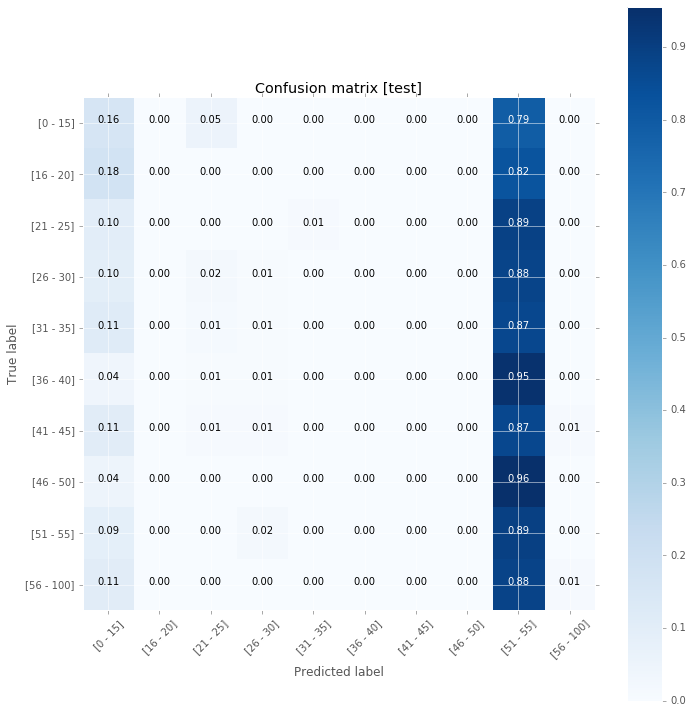

In [7]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict_classes(X_test, batch_size=batch_size, verbose=0)

cm = confusion_matrix(y_test_age, y_pred[0])
plot_utils.plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Confusion matrix [test] age')

cm = confusion_matrix(y_test_gender, y_pred[1])
plot_utils.plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Confusion matrix [test] gender')